# Info

Setting up the model to recreate the oscillating basin from the non-hydrostatic manual <br>
[Link to the manual](https://oss.deltares.nl/documents/4142077/4199062/non-hydrostatic_report_draft.pdf/eadc1aff-6e19-6e82-2747-3c11c30457ee?t=1624871720408)


Testing the updated xBeach toolbox to see if it can create the non-hydrostatic model

In [75]:
# import default modules
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from matplotlib import cm
import sys
import os
import subprocess

# Set global constants
PI = np.pi

# method to import xbtools with try routine
try:
    import xbTools
except ImportError:
    print('**no xbTools installation found in environment, adding parent path of notebook to see if it works')
    sys.path.append(r"C:\ERDC\xbeach-toolbox")

In [76]:
## import xbeach tools
#sys.path.append(os.path.abspath(os.path.join('..' )))

from xbTools.grid.creation import xgrid, ygrid
from xbTools.grid.extension import seaward_extend
from xbTools.xbeachtools import XBeachModelSetup
from xbTools.general.wave_functions import offshore_depth
from xbTools.xbeachpost import XBeachModelAnalysis
from xbTools.general.executing_runs import generate_batch_script, run_batch_script



In [77]:
def create_directory_if_not_exists(directory_path):
    """
    Creates a directory if it does not already exist.
    
    Parameters:
    directory_path (str): The path of the directory to create.
    """
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' created.")
    else:
        print(f"Directory '{directory_path}' already exists.")

def get_script_directory():
    try:
        # This will work if the script is run directly
        script_path = os.path.abspath(__file__)
    except NameError:
        # This will work in an interactive environment like Jupyter
        script_path = os.path.abspath('')
    
    return script_path

### Import library functions

In [78]:
sys.path.append(r"C:\ERDC\tutorial_models")

from lib.solitary_funcs import (calc_L_scaling, calc_wave_speed, calc_surface_elevation,
                                calc_u_vel, calc_v_vel, calc_depth_average_u)


### Define the model parameters

In [79]:
# Define model parameters
nx = 16000
model_time = 40

# Setting the analytical solution time higher than the model time to see if the jump goes away
analy_time = 45
num_analy_times = 1000
# Define paramters for analytical solution
epsilon = 0.1
g  = 9.81
d0 = 1.0


### Setup the model directories

In [80]:
# Get the folder of the current script
script_dir = get_script_directory()

# Make the epsilon value into a string and remove the "."
epsilon_str = str(epsilon).replace(".", "")

# Generate the model directory
model_dir = os.path.join(script_dir, f"")

create_directory_if_not_exists(model_dir)

exe_path = r"C:\ERDC\tutorial_models\XBeach_1.24.6057_Halloween_win64_netcdf\xbeach.exe"

# Make the batch file in the model dir
generate_batch_script(model_dir, exe_path, batch_file_name = "run_model.bat", 
                      include_cd = False, batch_file_folder = None)


batch_file_path = os.path.join(model_dir, "run_model.bat")

print("Script directory is: {}".format(script_dir))

print(f"Batch file path: {batch_file_path}")

Directory 'c:\ERDC\tutorial_models\solitary_wave\9_sol_wave_t_stop_40_CFL_075_checking_ringing\' already exists.
Script directory is: c:\ERDC\tutorial_models\solitary_wave\9_sol_wave_t_stop_40_CFL_075_checking_ringing
Batch file path: c:\ERDC\tutorial_models\solitary_wave\9_sol_wave_t_stop_40_CFL_075_checking_ringing\run_model.bat


### Calc the analytical solution

In [81]:
# Model parameters
# The model domain length and simulation time also change with the incident wave height

L_sol = calc_L_scaling(epsilon, delta_scaling=1/20) # Length of the solitary wave
model_length = 100 * L_sol                             # Length of the domain
x0 = -2 * L_sol                                     # Initial x-offset

c = calc_wave_speed(g, epsilon, d0)

print("Scaling wave lengths: {}".format(L_sol))
print("Channel Lengths: {}".format(model_length))
print("x0 Locations: {}".format(x0))
print("Wave speed: {}".format(c))

Scaling wave lengths: 7.953925506456178
Channel Lengths: 795.3925506456178
x0 Locations: -15.907851012912356
Wave speed: 3.2841662030181356


In [82]:
# Set the index for the current wave
index = 0

# Select the time arr
time = np.linspace(0, analy_time, num_analy_times)

x_location = 0.0
# Calc the x velocity
u_vel = calc_u_vel(epsilon, x0 = x0, x = x_location, y = d0, t = time, g = g, d0 = d0)

# Calc the y velocity
v_vel = calc_v_vel(epsilon, x0 = x0, x = x_location, y = d0, t = time, g = g, d0 = d0)

# Calc the water surface elevation
eta = calc_surface_elevation(epsilon, x0, x= x_location, t = time, g = g, d0 = d0)

# Calc the average u velocity
u_avg = calc_depth_average_u(epsilon, x0, x = x_location, t = time, g = g, d0 = d0)

In [83]:
# Calc an average V-Velocity to facilate testing

# Init variable to hold the average
v_avg = 0

# Set a tolerance for how much the velocity changes by
num_depths = 100

# Make an array to hold the depths the v-velocity should be calculated at
depths = np.linspace(0, d0, num_depths)

for depth in depths:
    # Calc the v-velocity and sum it
    v_avg += calc_v_vel(epsilon, x0 = x0, x = x_location, 
                        y = depth, t = time, g = g, d0 = d0)

# Average the value
v_avg= v_avg/num_depths

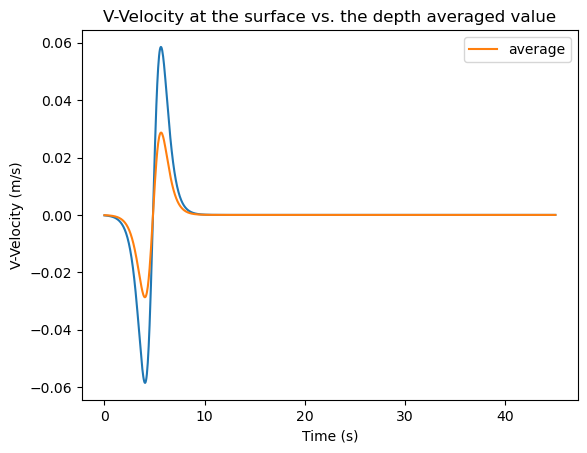

In [84]:
plt.plot(time, v_vel)
plt.plot(time, v_avg, label = "average")

plt.title("V-Velocity at the surface vs. the depth averaged value")
plt.xlabel("Time (s)")
plt.ylabel("V-Velocity (m/s)")
plt.legend()
plt.show()

### Generate the mesh

In [85]:
# Generate the x-mesh
xgr = np.linspace(0, model_length, nx+1)

# Set the y-mesh as none since the model is 1D
ygr = None

# Generate the bathymetry
floor_depth = 0.0
zgr = np.ones(nx + 1) * floor_depth

### Create the model setup
Generating the model setup using the xBeach toolbox

In [86]:
xb_setup = XBeachModelSetup('test')

xb_setup.set_grid(xgr, ygr, zgr, posdwn=-1, alfa=0)
xb_setup.set_nebed(np.ones_like(zgr))
xb_setup.set_friction(np.ones_like(zgr))

In [87]:
boun_U_dict = {"make_file": True,
               "file_name": "boun_U.bcf",
               "dimension": "vector",
               "variable_dict": {
                   "t" : time,
                   "U" : u_avg, # NOTE: Changed these to surface velocities 
                   "W" : v_avg,
                   "zs": eta - d0 # Pertubation from the intial water surface
               }         
}

xb_setup.set_waves('ts_nonh', input_struct=boun_U_dict)


In [104]:
xb_setup.set_params({"wbctype"      : "ts_nonh",
                     'wavemodel'    : 'nonh',
                     'nonh'         : 1,
                     'CFL'          : 0.5,
                     'nonhq3d'      : 1,
                     'nhlay'        : 0.33, 
                     'viscosity'    : 0, 
                     'lwave'        : 0, 
                     'bedfriccoef'  : 0.0,
                     'morphology'   : 0,
                     'zs0'          : 1,
                     'order'        : 1,
                     'ARC'          : 1, 
                     'front'        : "nonh_1d", 'back'         : "abs_1d" ,
                     'left'         : "neumann", 'right'        : "neumann",

                     'tstop'        : model_time,
                     
                     "tintm"        : 0.1,
                     "tintp"        : 0.1,
                     "tintg"        : 0.1,
                     'nglobalvar'   : ['zs', 'zb', 'H', "u", "v"],
})


The following params were not found in the JSON: 
{'nonh': 1}


In [105]:
xb_setup.input_par

{'par': {'nonh': 1},
 'Wave boundary condition parameters': {'wbctype': 'ts_nonh'},
 'Physical processes': {'wavemodel': 'nonh',
  'viscosity': 0,
  'lwave': 0,
  'morphology': 0},
 'Model time': {'CFL': 0.5, 'tstop': 40},
 'Non-hydrostatic correction parameters': {'nonhq3d': 1, 'nhlay': 0.33},
 'Flow parameters': {'bedfriccoef': 0.0},
 'Tide boundary conditions': {'zs0': 1},
 'Flow boundary condition parameters': {'order': 1,
  'ARC': 1,
  'front': 'nonh_1d',
  'back': 'abs_1d',
  'left': 'neumann',
  'right': 'neumann'},
 'Output': {'tintm': 0.1, 'tintp': 0.1, 'tintg': 0.1},
 '_Output': {'nglobalvar': ['zs', 'zb', 'H', 'u', 'v']}}

In [106]:
xb_setup.write_model(model_dir, num_dec_dig=10)

Data written to c:\ERDC\tutorial_models\solitary_wave\9_sol_wave_t_stop_40_CFL_075_checking_ringing\boun_U.bcf


### Run and analyze the model

In [107]:

# # Set the working directory to where the batch file is located
# working_directory = os.path.dirname(batch_file_path)

# try:
#     # Execute the batch file, capturing both stdout and stderr
#     result = subprocess.run(batch_file_path, check=True, shell=True, cwd=working_directory, capture_output=True, text=True)
    
#     # Print success message and output
#     print(f"Batch file '{batch_file_path}' executed successfully.")
#     print("Output:")
#     print(result.stdout)
# except subprocess.CalledProcessError as e:
#     # Print error message and captured stderr
#     print(f"An error occurred while executing the batch file: {e}")
#     print("Error output:")
#     print(e.stderr)


run_batch_script(batch_file_path, flag_print_Blog = False)


Batch file 'c:\ERDC\tutorial_models\solitary_wave\9_sol_wave_t_stop_40_CFL_075_checking_ringing\run_model.bat' executed successfully.


In [108]:
results = XBeachModelAnalysis(fname = "foo", 
                              model_path=model_dir)

In [109]:
results.set_save_fig(False)
results.set_plot_localcoords(False)
results.set_plot_km_coords(False)

loading variable zs from file
loading variable zb from file
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded


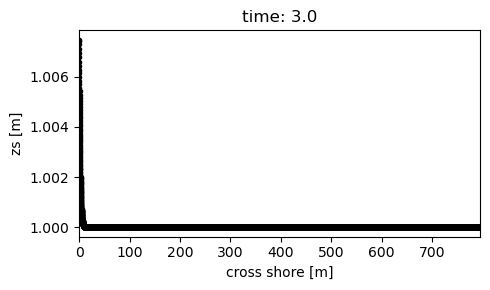

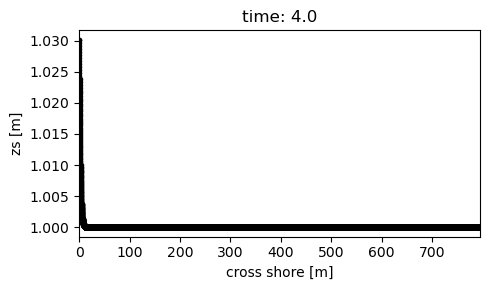

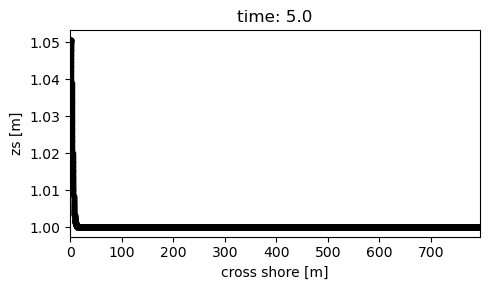

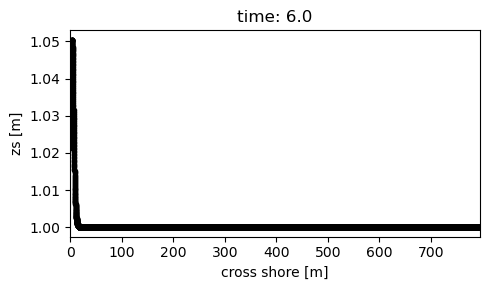

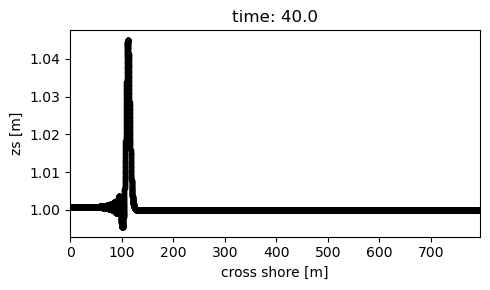

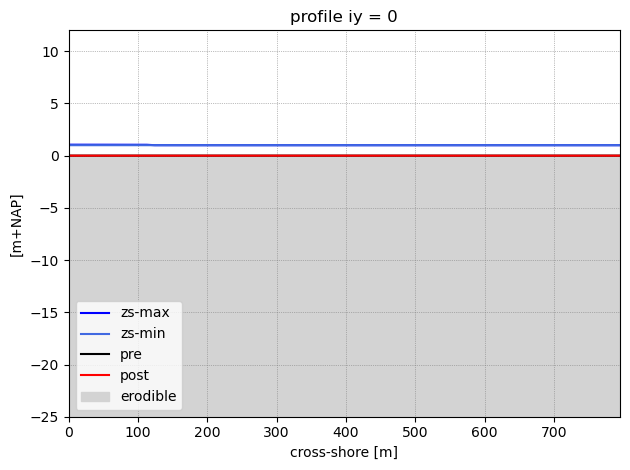

In [110]:
indices = [30, 40, 50, 60, 400]

for index in indices:
    fig, ax = results.fig_cross_var('zs', index, iy=0, coord=None, plot_ref_bathy=False, zmin=-1)

fig, ax = results.fig_profile_change(iy=0)

dx: 0.04971203441535111
Approx. length of the wave: 13


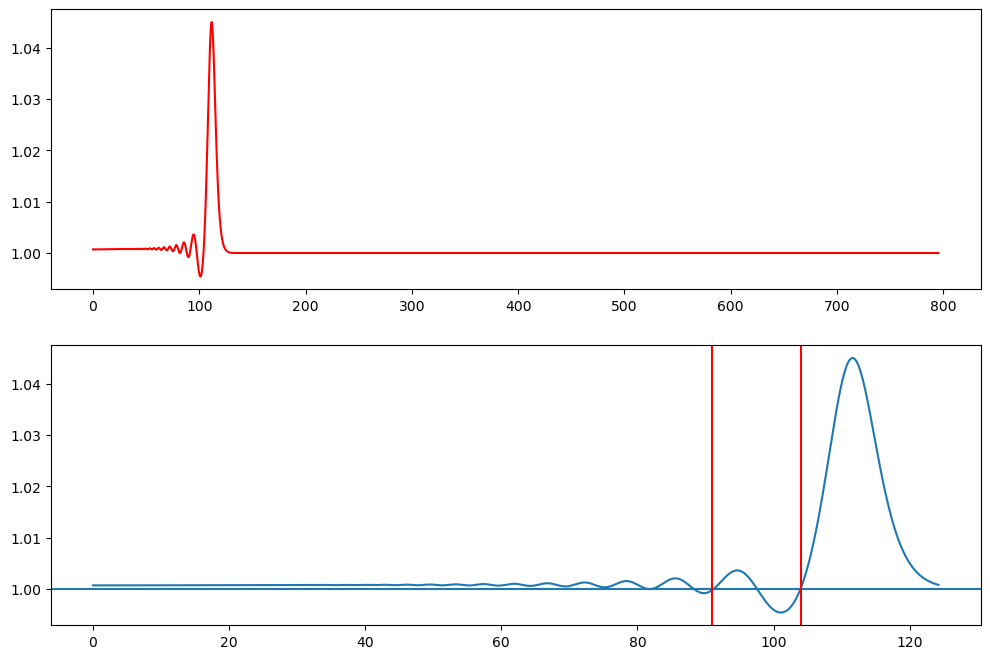

In [111]:
dx = xgr[1] - xgr[0]

x_major_ticks = xgr  # Major ticks for x-axis (spacing 2)

# Apply major ticks to the grid
# plt.xticks(x_major_ticks)

# Make a subplot
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 8))

eta_data = results.var["zs"][index, 0, :]

axs[0].plot(xgr, eta_data, label = "xBeach Surface Elevation", color = "red")

begin = 0
end = begin +2500

axs[1].plot(xgr[begin:end], eta_data[begin:end])
axs[1].axhline(y = 1.0)
axs[1].axvline(x = 104, color = "red")
axs[1].axvline(x = 91, color = "red")

print(f"dx: {dx}")
print(f"Approx. length of the wave: {104-91}")
# axs[2].plot(xgr, v_data, label = "xBeach vertical vel.")
# axs[2].plot(xgr, analytical_v, linestyle= "dashed", label = "Analytical Sln.")
plt.show()

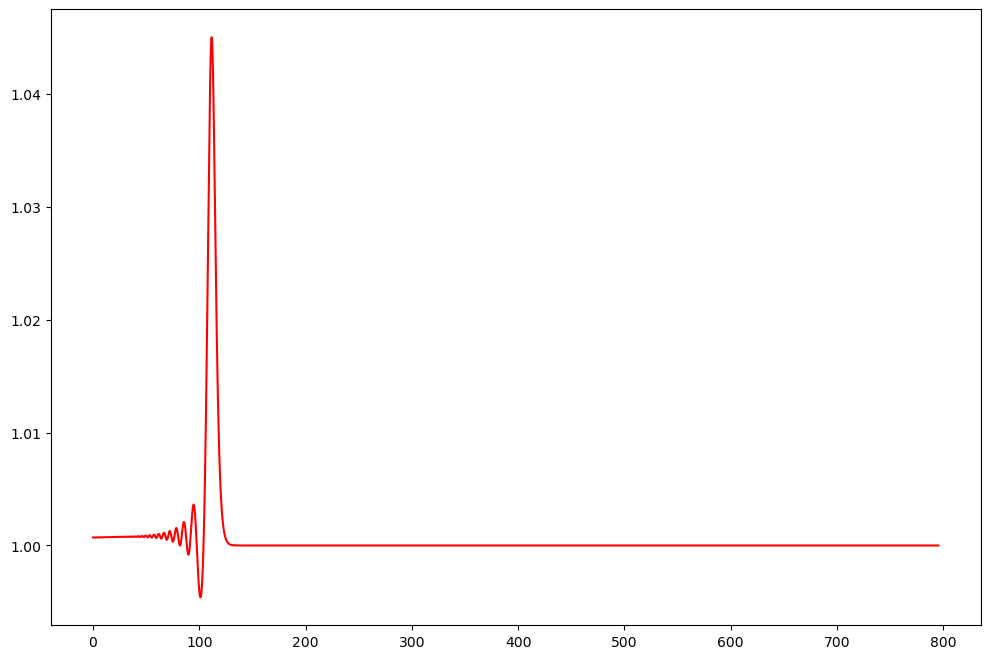

In [99]:
# Make a subplot
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 8))

eta_data = results.var["zs"][index, 0, :]

axs.plot(xgr, eta_data, label = "xBeach Surface Elevation", color = "red")

# axs[2].plot(xgr, v_data, label = "xBeach vertical vel.")
# axs[2].plot(xgr, analytical_v, linestyle= "dashed", label = "Analytical Sln.")
plt.show()